In [ ]:
# Setup 기본 설정
import numpy as np
import matplotlib.pyplot as plt

# Setup FIR 필터링을 위한 scipy.signal 임포트
from scipy.signal import lfilter, freqz
from scipy.signal import firwin   # firwin 사용
from scipy.signal import remez    # remez 사용
from scipy.signal import firls    # firls 사용

#
# Jupyter에서 그래프 크게 보기
#
plt.rcParams["figure.figsize"] = (8, 3)

## **1. RF Mixer Output Setup** 

In [ ]:
# RF Mixer - 곱셈(Multiplication)으로 주파수/위상 차이 생성

fs = 2000_000        # Sampling Frequency 2000 kHz 
T  = 0.000125        # 0.125 ms   Y축 
t  = np.linspace(0, T, int(fs*T), endpoint=False)

f_lo = 100_000      # LO = 100 kHz
f_rf = 120_000      # RF = 120 kHz

phase_lo = 0.0
phase_rf = np.deg2rad(30)  # RF 위상 30도

lo = np.cos(2*np.pi*f_lo*t + phase_lo)
rf = np.cos(2*np.pi*f_rf*t + phase_rf)

# RF Mixer: 곱셈
y_rf = lo * rf      # x_out = x1 * x2

# Δf Frequency Difference and Sum
f_dif_1 = abs(f_rf - f_lo)  # 20 kHz
f_sum_1 = abs(f_rf + f_lo)  # 220 kHz

# Δφ Phase Difference and Sum
phase_dif = phase_rf - phase_lo   
phase_sum = phase_rf + phase_lo
phi_diff_deg = np.rad2deg(phase_dif) # 도(degree)로 보기 좋게
phi_pi = phase_dif / np.pi  # π 기준 환산

# Expected Comparison Signals (믹서 곱셈의 결과가 0.5 배이므로)
ideal_020k = 0.5 * np.cos(2*np.pi*f_dif_1*t + phase_dif)
ideal_220k = 0.5 * np.cos(2*np.pi*f_sum_1*t + phase_sum)



## **2. FIR Filters Comaparison**   

* [FIR Filter Design](https://en.wikipedia.org/wiki/Finite_impulse_response#Filter_design)
    * **Window design method(Hamming)**   
    * Frequency Sampling method   
    * **Conventional linear programming(least_squares)**   
    * **Iterative linear programming(Equiripple)** 

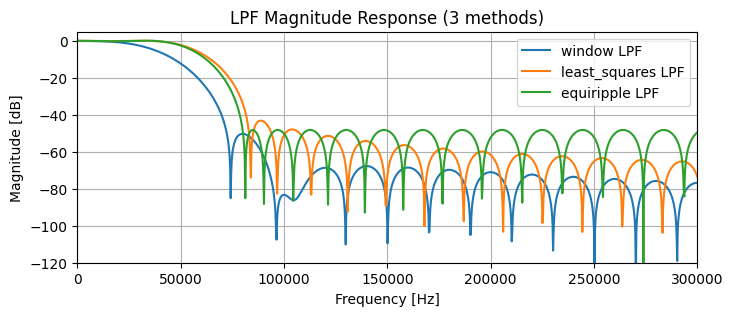

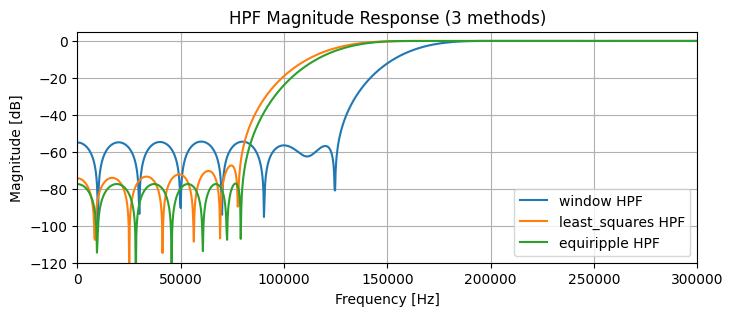

**FIR-window** Filter:
|     RMS       |  Peak          |
|-----------------------|------------------------|
| LPF: `5.4818e-02`  |  LPF: `2.8400e-01` |
| HPF: `2.3289e-02`  |  HPF: `2.2903e-01` |


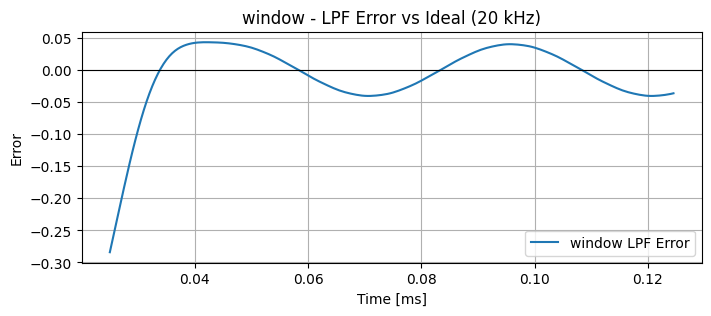

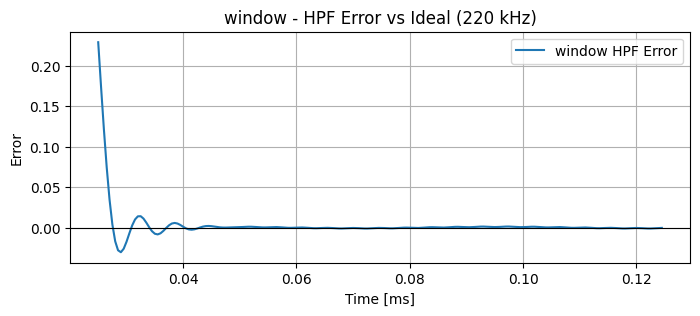

**FIR-least_squares** Filter:
|     RMS       |  Peak          |
|-----------------------|------------------------|
| LPF: `3.2557e-02`  |  LPF: `2.4172e-01` |
| HPF: `2.3661e-02`  |  HPF: `2.2544e-01` |


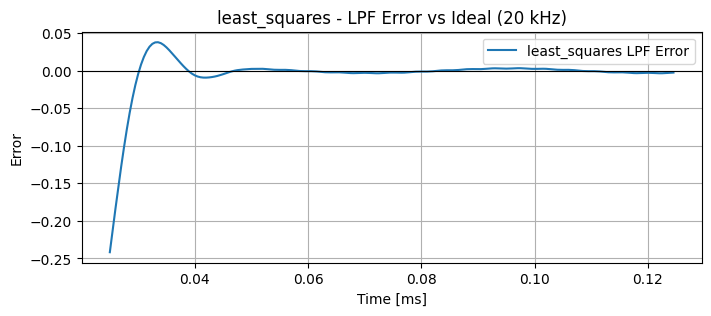

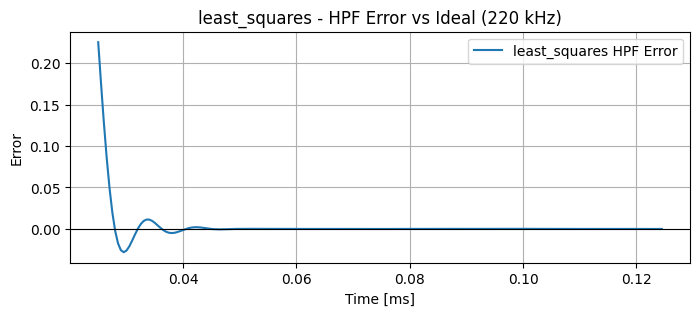

**FIR-equiripple** Filter:
|     RMS       |  Peak          |
|-----------------------|------------------------|
| LPF: `3.3728e-02`  |  LPF: `2.4508e-01` |
| HPF: `2.3470e-02`  |  HPF: `2.2537e-01` |


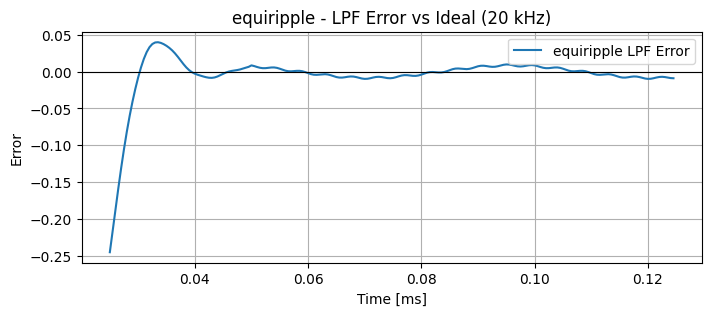

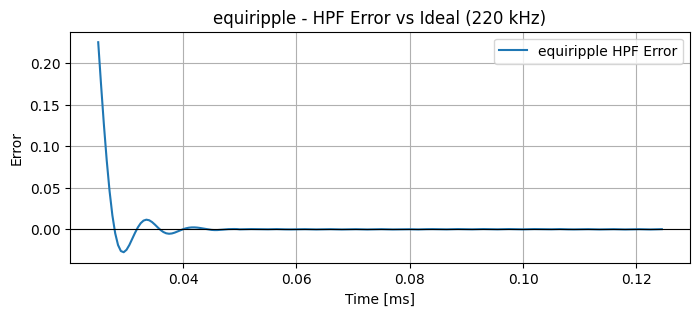

In [ ]:
from IPython.display import Markdown, display

num_taps = 101        # FIR 필터 탭 수 (데모용으로 101, 원하면 더 늘려도 됨)


lpf_pb = 40_000
lpf_sb = 80_000
hpf_sb = 80_000
hpf_pb = 160_000

filters = {}

# (a) Window Method (firwin, Hamming 기본)
filters["window"] = {
    "lpf": firwin(num_taps, cutoff=lpf_pb, fs=fs),               # LPF
    "hpf": firwin(num_taps, cutoff=hpf_pb, fs=fs, pass_zero=False)  # HPF
}

# (b) Least-Squares (Conventional Linear Programming, firls)
filters["least_squares"] = {
    "lpf": firls(
        numtaps=num_taps,
        bands=[0, lpf_pb, lpf_sb, fs/2],
        desired=[1, 1, 0, 0],
        fs=fs
    ),
    "hpf": firls(
        numtaps=num_taps,
        bands=[0, hpf_sb, hpf_pb, fs/2],
        desired=[0, 0, 1, 1],
        fs=fs
    )
}

# (c) Equiripple (Iterative Linear Programming, remez)
filters["equiripple"] = {
    "lpf": remez(
        num_taps,
        bands=[0, lpf_pb, lpf_sb, fs/2],
        desired=[1, 0],
        weight=[1, 5],
        fs=fs
    ),
    "hpf": remez(
        num_taps,
        bands=[0, hpf_sb, hpf_pb, fs/2],
        desired=[0, 1],
        weight=[5, 1],
        fs=fs
    )
}


# ------------------------------
# 2) 주파수 응답 비교
# ------------------------------
plt.figure()
for name, fdict in filters.items():
    w, H = freqz(fdict["lpf"], 1, worN=4096, fs=fs)
    plt.plot(w, 20*np.log10(np.maximum(np.abs(H), 1e-8)), label=f"{name} LPF")
plt.xlim(0, 300_000)
plt.ylim(-120, 5)
plt.grid(True)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.title("LPF Magnitude Response (3 methods)")
plt.legend()
plt.show()

plt.figure()
for name, fdict in filters.items():
    w, H = freqz(fdict["hpf"], 1, worN=4096, fs=fs)
    plt.plot(w, 20*np.log10(np.maximum(np.abs(H), 1e-8)), label=f"{name} HPF")
plt.xlim(0, 300_000)
plt.ylim(-120, 5)
plt.grid(True)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.title("HPF Magnitude Response (3 methods)")
plt.legend()
plt.show()

delay = (num_taps - 1) // 2

for name, fdict in filters.items():
    lpf = fdict["lpf"]
    hpf = fdict["hpf"]

    # Mixer 출력에 적용 (y_rf, t, ideal_020k, ideal_220k 는 이미 있다고 가정)
    y_lpf = lfilter(lpf, 1.0, y_rf)
    y_hpf = lfilter(hpf, 1.0, y_rf)

    t_valid       = t[delay:]
    y_lpf_valid   = y_lpf[delay:]
    y_hpf_valid   = y_hpf[delay:]

    ideal_20k_valid  = ideal_020k[:len(y_lpf_valid)]
    ideal_220k_valid = ideal_220k[:len(y_hpf_valid)]

    # Error
    error_lpf = y_lpf_valid - ideal_20k_valid
    error_hpf = y_hpf_valid - ideal_220k_valid

    rms_lpf = np.sqrt(np.mean(error_lpf**2))
    rms_hpf = np.sqrt(np.mean(error_hpf**2))
    peak_lpf = np.max(np.abs(error_lpf))
    peak_hpf = np.max(np.abs(error_hpf))

    display(Markdown(        
        f"**FIR-{name}** Filter:\n"
        f"|     RMS       |  Peak          |\n"
        f"|-----------------------|------------------------|\n"
        f"| LPF: `{rms_lpf:.4e}`  |  LPF: `{peak_lpf:.4e}` |\n"
        f"| HPF: `{rms_hpf:.4e}`  |  HPF: `{peak_hpf:.4e}` |\n"
    ))

    # 원하면 에러 파형도 그림
    plt.figure()
    plt.plot(t_valid*1000, error_lpf, label=f"{name} LPF Error")
    plt.axhline(0, color='k', linewidth=0.8)
    plt.xlabel("Time [ms]")
    plt.ylabel("Error")
    plt.title(f"{name} - LPF Error vs Ideal (20 kHz)")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(t_valid*1000, error_hpf, label=f"{name} HPF Error")
    plt.axhline(0, color='k', linewidth=0.8)
    plt.xlabel("Time [ms]")
    plt.ylabel("Error")
    plt.title(f"{name} - HPF Error vs Ideal (220 kHz)")
    plt.grid(True)
    plt.legend()
    plt.show()
